# 🤪 Variational Autoencoders on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own autoencoder on the CelebA faces dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [4]:
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [5]:
# Load the data
train_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [6]:
# Preprocess the data
def preprocess(img):
    """
    Normalize the images
    """
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

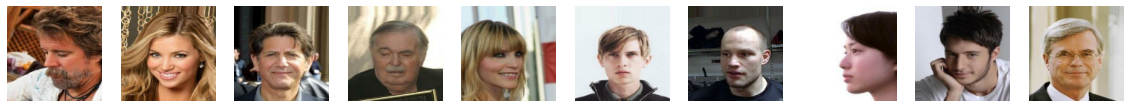

In [7]:
# Show some faces from the training set
display(np.array(list(train.take(1).get_single_element())), cmap = None)

## 2. Build the variational autoencoder <a name="build"></a>

In [8]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Encoder
encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")
x = Conv2D(NUM_FEATURES, (3, 3), strides=2, padding="same")(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = Flatten()(x)
z_mean = Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [10]:
# Decoder
decoder_input = Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(NUM_FEATURES, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
decoder_output = Conv2DTranspose(CHANNELS, (3, 3), strides=1, activation = "sigmoid", padding="same")(x)
decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 1024)              205824    
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         36928     
 nspose)                                                     

In [27]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * root_mean_squared_error(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * root_mean_squared_error(data, reconstruction, axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1))
        total_loss = reconstruction_loss + kl_loss
      
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    

In [28]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [29]:
# Compile the variational autoencoder
optimizer = Adam(learning_rate = LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [33]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = TensorBoard(log_dir="./logs2")

In [34]:
# Load old weights if required
LOAD_MODEL = True
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(test.take(1))

In [35]:
history = vae.fit(
    train,
    epochs=EPOCHS*10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=test,
    initial_epoch = 8,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 9/100
1267/1267 [==============================] - 4152s 3s/step - loss: 285.6204 - reconstruction_loss: 235.3416 - kl_loss: 50.2114 - val_loss: 288.2035 - val_reconstruction_loss: 238.9389 - val_kl_loss: 49.2646
Epoch 10/100
1267/1267 [==============================] - 4126s 3s/step - loss: 285.9046 - reconstruction_loss: 235.2334 - kl_loss: 50.3308 - val_loss: 284.2599 - val_reconstruction_loss: 234.4035 - val_kl_loss: 49.8564
Epoch 11/100
1267/1267 [==============================] - 4148s 3s/step - loss: 285.5074 - reconstruction_loss: 234.6931 - kl_loss: 50.5087 - val_loss: 280.9045 - val_reconstruction_loss: 230.7153 - val_kl_loss: 50.1892
Epoch 12/100
1267/1267 [==============================] - 4141s 3s/step - loss: 284.9722 - reconstruction_loss: 234.1001 - kl_loss: 50.6380 - val_loss: 287.0379 - val_reconstruction_loss: 236.4874 - val_kl_loss: 50.5505
Epoch 13/100
1267/1267 [==============================] - 4146s 3s/step - loss: 284.7048 - reconstruction_loss: 233.6168 

KeyboardInterrupt: 

In [36]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets
INFO:tensorflow:Assets written to: ./models/encoder/assets
INFO:tensorflow:Assets written to: ./models/decoder/assets
